In [1]:
!pip install xgboost

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [7]:
#store = pd.HDFStore('X_pca.h5')
#X_pca = store['X_pca']

store = pd.HDFStore('X_pca.h5')
X_pca = store['X_pca']

store = pd.HDFStore('X_mob.h5')
X_mob = store['X_mob']


store = pd.HDFStore('y_default.h5')
y_default = store['y_default']

store = pd.HDFStore('y_prepay.h5')
y_prepay = store['y_prepay']

X_pca = X_pca.join(X_mob)

In [8]:
X_pca_add = X_pca[ X_pca['mob']>1].copy()
X_pca_add['mob'] = np.ceil(X_pca_add['mob']/2)
X_pca = pd.concat([X_pca, X_pca_add])

zeros = pd.DataFrame(np.zeros(X_pca_add.shape[0]))
y_default = pd.concat([y_default,zeros])
y_prepay = pd.concat([y_prepay,zeros])

In [9]:
X_pca_add = X_pca[ X_pca['mob']>10].copy()
X_pca_add['mob'] = np.ceil(X_pca_add['mob']/10)
X_pca = pd.concat([X_pca, X_pca_add])

zeros = pd.DataFrame(np.zeros(X_pca_add.shape[0]))
y_default = pd.concat([y_default,zeros])
y_prepay = pd.concat([y_prepay,zeros])

In [10]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_default, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[09:30:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
No Skill: ROC AUC=0.500
XGBClassifier: ROC AUC=0.852


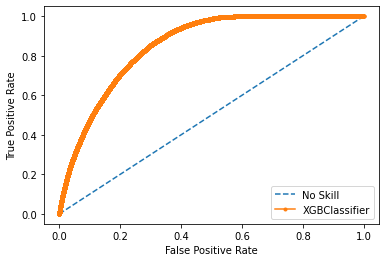

165.48750352859497 s


In [11]:
time_start = time.time()
model = xgb.XGBClassifier(max_depth= 3, n_estimators=100)
model.fit(trainX, trainy)
time_end = time.time()

# save the model to disk
filename = 'xgb_model_default.sav'
#filename = 'xgb_model_date_default.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))


# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print (time_end - time_start, "s")

In [12]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_prepay, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[09:33:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
No Skill: ROC AUC=0.500
XGBClassifier: ROC AUC=0.788


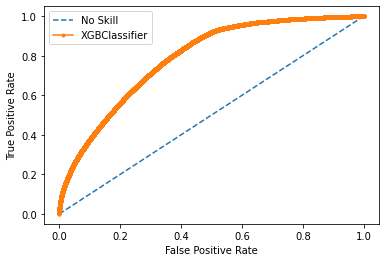

167.10369682312012 s


In [13]:
time_start = time.time()
model = xgb.XGBClassifier(max_depth= 3, n_estimators=100)
model.fit(trainX, trainy)
time_end = time.time()

filename = 'xgb_model_prepay.sav'
#filename = 'xgb_model_date_prepay.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print (time_end - time_start, "s")